# imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import Uncertainty as unc
import UncertaintyM as uncM
import Data.data_provider as dp
import matplotlib.pyplot as plt

# Loading data

In [2]:
data_name = "spambase"
features, target = dp.load_data(data_name)

# split and shuffel the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=True, random_state=1)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=1)

In [3]:
model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("model test score = ", model.score(X_test, y_test))

model test score =  0.9217391304347826


In [4]:
total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc.model_uncertainty(model, X_test, X_train, y_train)

In [5]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

model_calib = CalibratedClassifierCV(model, cv=20, method="isotonic")
model_calib.fit(X_valid, y_valid)
print("model test score = ", model_calib.score(X_test, y_test))

total_uncertainty_calib = unc.calib_ens_total_uncertainty(model_calib, X_test)

model test score =  0.9282608695652174


In [6]:
total_uncertainty_mcalib, epistemic_uncertainty_mcalib, aleatoric_uncertainty_mcalib = unc.calib_ens_member_uncertainty(model, X_test, X_train, y_train, X_valid, y_valid)

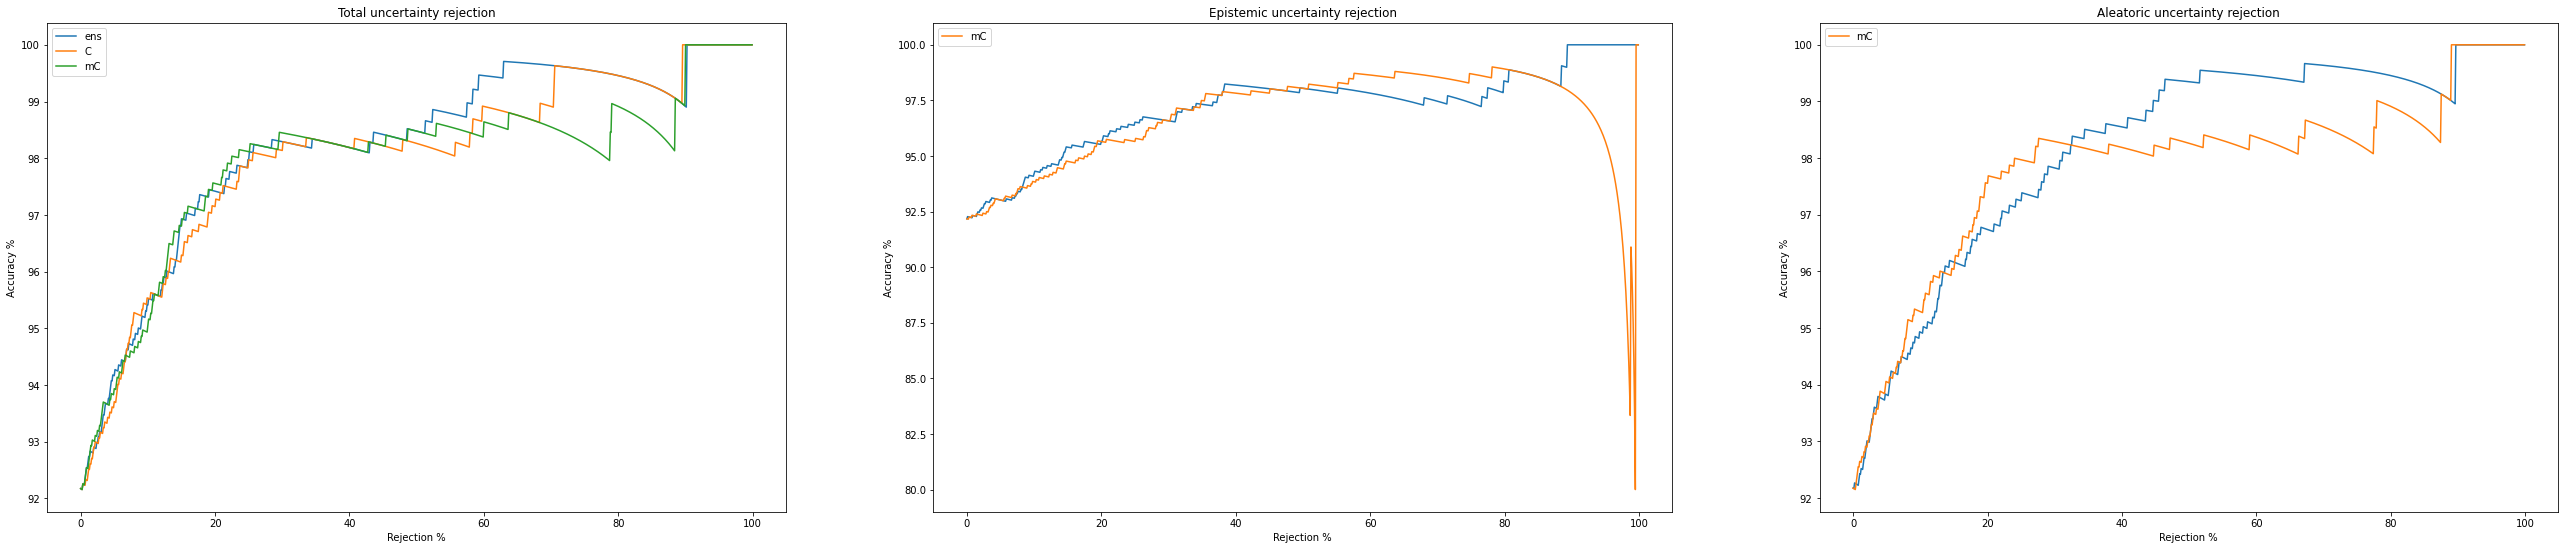

In [8]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(3*3)
fig.set_figwidth(15*3)

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), total_uncertainty.reshape((1,-1)))
avg_acc_c, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), total_uncertainty_calib.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), total_uncertainty_mcalib.reshape((1,-1)))
axs[0].plot(steps, avg_acc*100, label='ens')
axs[0].plot(steps, avg_acc_c*100, label='C')
axs[0].plot(steps, avg_acc_mc*100, label='mC')
axs[0].legend()
axs[0].set_title("Total uncertainty rejection")

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty_mcalib.reshape((1,-1)))

axs[1].plot(steps, avg_acc*100)
axs[1].set_title("Epistemic uncertainty rejection")
axs[1].plot(steps, avg_acc_mc*100, label='mC')
axs[1].legend()

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), aleatoric_uncertainty.reshape((1,-1)))
avg_acc_mc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), aleatoric_uncertainty_mcalib.reshape((1,-1)))

axs[2].plot(steps, avg_acc*100)
axs[2].set_title("Aleatoric uncertainty rejection")
axs[2].plot(steps, avg_acc_mc*100, label='mC')
axs[2].legend()

for i in range(3):
    axs[i].set(xlabel="Rejection %", ylabel="Accuracy %")

fig.show()